# EDA Binary Classification with a Bank Dataset

### This EDA refers to Kaggle playground competition: "Binary Classification with a Bank Dataset" 
- Competition link: https://www.kaggle.com/competitions/playground-series-s5e8
- Main goal of this competition is to predict whether a client will subscribe to a bank term deposit.
- Submissions are evaluated using ROC AUC between the predicted value and the observed target.
- The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Marketing Dataset dataset. Feature distributions are close to, but not exactly the same, as the original.
- Start Date - August 1, 2025
- Final Submission Deadline - August 31, 2025

### Labels details from oryginal data set

- age: Age of the client (numeric)
- job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
- marital: Marital status (categorical: "married", "single", "divorced")
- education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
- default: Has credit in default? (categorical: "yes", "no")
- balance: Average yearly balance in euros (numeric)
- housing: Has a housing loan? (categorical: "yes", "no")
- loan: Has a personal loan? (categorical: "yes", "no")
- contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")
- day: Last contact day of the month (numeric, 1-31)
- month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
- duration: Last contact duration in seconds (numeric)
- campaign: Number of contacts performed during this campaign (numeric)
- pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)
- previous: Number of contacts performed before this campaign (numeric)
- poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
- y: The target variable, whether the client subscribed to a term deposit

In [3]:
from scipy.stats import chi2_contingency
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)


/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [29]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

## 1. Basic check of data

In [5]:
display(train_df.head(4))
display(test_df.head(4))

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown


In [6]:
display(train_df.info())
print('')
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


None

In [7]:
display("Summary for TRAIN data:",train_df.describe())
display("Summary for TEST data:",test_df.describe())

'Summary for TRAIN data:'

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


'Summary for TEST data:'

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [8]:
display("TRAIN data", train_df.nunique())
print('\n')
display('TEST data',test_df.nunique())

'TRAIN data'

id           750000
age              78
job              12
marital           3
education         4
default           2
balance        8217
housing           2
loan              2
contact           3
day              31
month            12
duration       1760
campaign         52
pdays           596
previous         50
poutcome          4
y                 2
dtype: int64

'TEST data'

id           250000
age              76
job              12
marital           3
education         4
default           2
balance        7073
housing           2
loan              2
contact           3
day              31
month            12
duration       1620
campaign         49
pdays           518
previous         47
poutcome          4
dtype: int64

### Key Observations:
- We have 5 numeric columns and 2 with categories, One coulmn with id in both train/test sets and additional column with labels in train
- train/test sets have same min max values and similar statistics
- train/test sets have have same number of unique values

## 2. Duplicates and missing values check

In [9]:
display("Duplicates in TRAIN data:", train_df.duplicated().sum())
display("Duplicates in TEST data:", test_df.duplicated().sum())

'Duplicates in TRAIN data:'

0

'Duplicates in TEST data:'

0

In [10]:
print("Missing values in TRAIN data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in TEST data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in TRAIN data:
 id           0.00%
age          0.00%
job          0.00%
marital      0.00%
education    0.00%
default      0.00%
balance      0.00%
housing      0.00%
loan         0.00%
contact      0.00%
day          0.00%
month        0.00%
duration     0.00%
campaign     0.00%
pdays        0.00%
previous     0.00%
poutcome     0.00%
y            0.00%
dtype: object

Missing values  in TEST data:
 id           0.00%
age          0.00%
job          0.00%
marital      0.00%
education    0.00%
default      0.00%
balance      0.00%
housing      0.00%
loan         0.00%
contact      0.00%
day          0.00%
month        0.00%
duration     0.00%
campaign     0.00%
pdays        0.00%
previous     0.00%
poutcome     0.00%
dtype: object


### Key Observations:
- There is no duplicates in train/test data
- There are missing data in train/test sets in range 5.6% to 10.2% depending on coulumn
- Stage_fear column has the largest amount of missing data, rest of columns have comparable number of missing values
- There is no major difference in the amount of missing data between train/test data

## 3. Train-Test drift check

In [11]:
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance

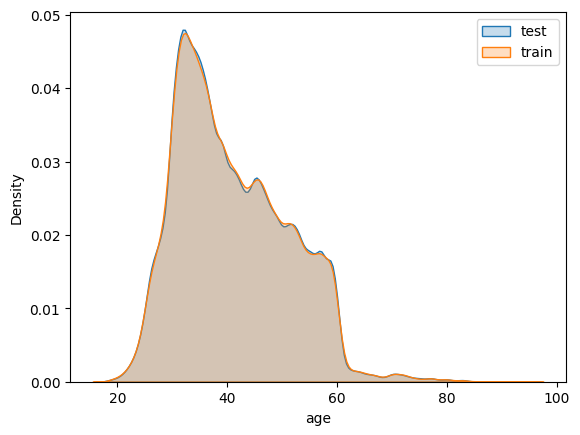

KS (Kolmogorov–Smirnov) p-value for age: 0.4197
Wasserstein Distance: 0.03092399999999996


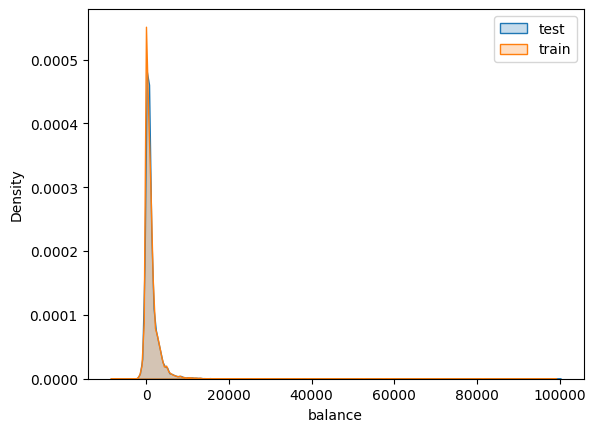

KS (Kolmogorov–Smirnov) p-value for balance: 0.7273
Wasserstein Distance: 9.750701333332215


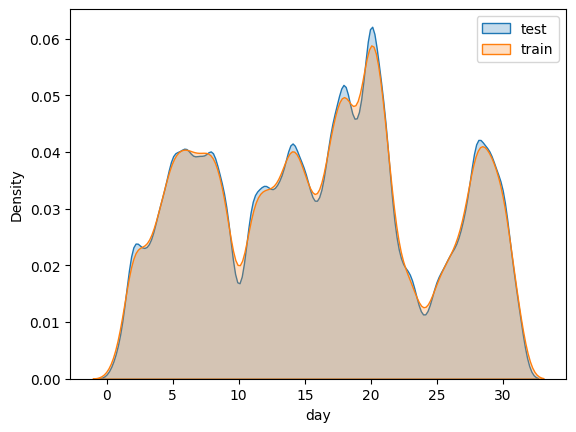

KS (Kolmogorov–Smirnov) p-value for day: 0.9915
Wasserstein Distance: 0.01220000000000002


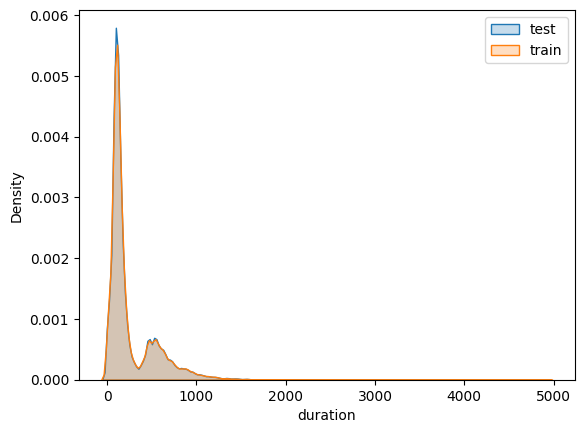

KS (Kolmogorov–Smirnov) p-value for duration: 0.5070
Wasserstein Distance: 0.9289506666666223


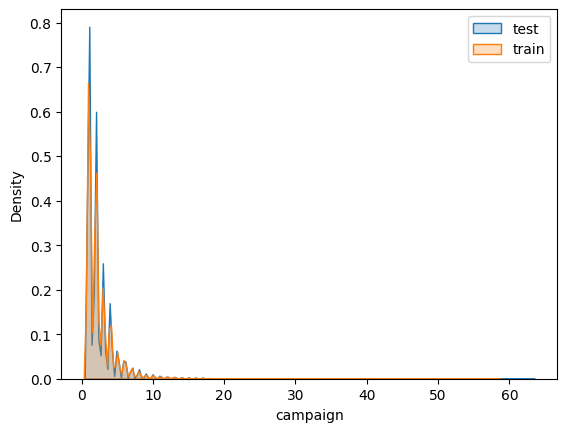

KS (Kolmogorov–Smirnov) p-value for campaign: 0.9637
Wasserstein Distance: 0.005550666666667092


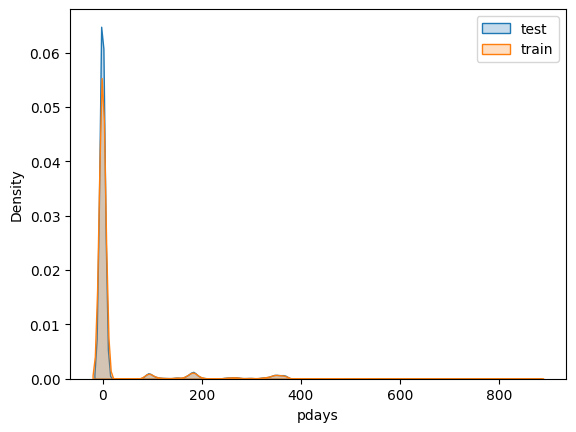

KS (Kolmogorov–Smirnov) p-value for pdays: 1.0000
Wasserstein Distance: 0.1405906666666683


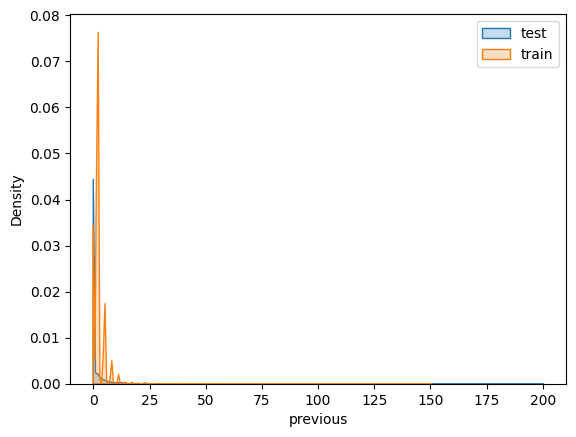

KS (Kolmogorov–Smirnov) p-value for previous: 1.0000
Wasserstein Distance: 0.005316000000001875


In [12]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(train_df[col], label='test', fill=True)
        sns.kdeplot(test_df[col], label='train', fill=True)
        plt.legend()
        plt.show()
        ks_stat, p_value = ks_2samp(train_df[col], test_df[col])
        print(f"KS (Kolmogorov–Smirnov) p-value for {col}: {p_value:.4f}")
        dist = wasserstein_distance(train_df[col], test_df[col])
        print(f"Wasserstein Distance: {dist}")

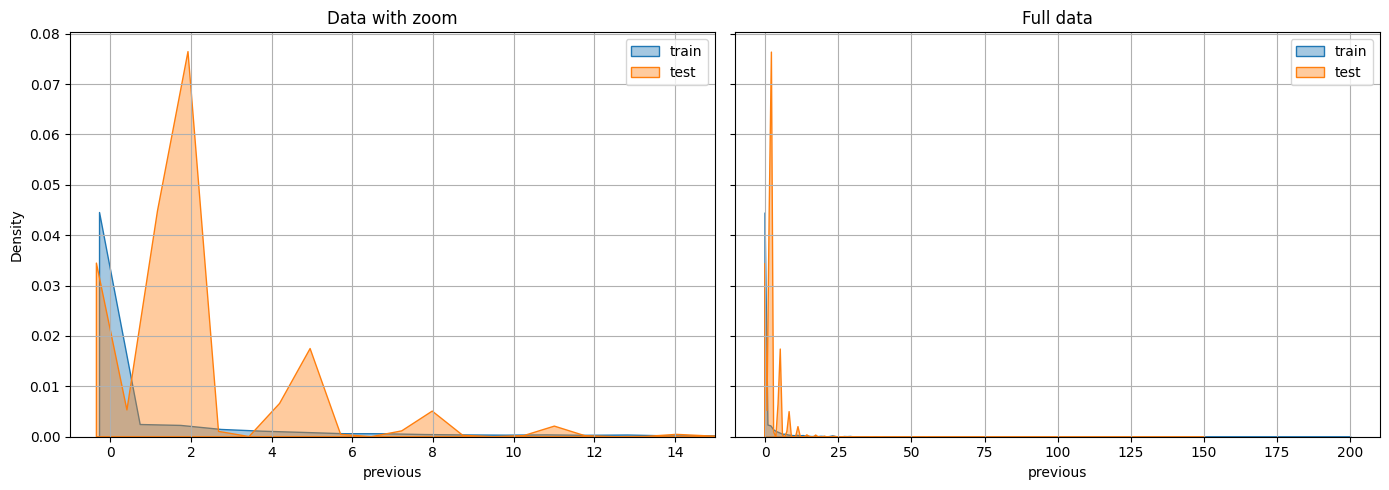

In [13]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.999)

# Przycięty
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Pełen
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

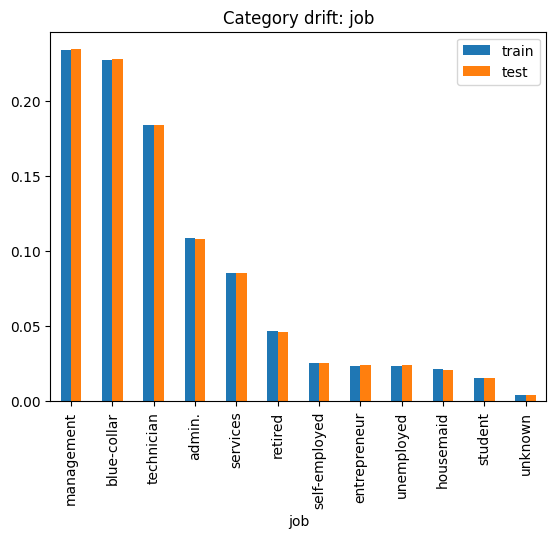

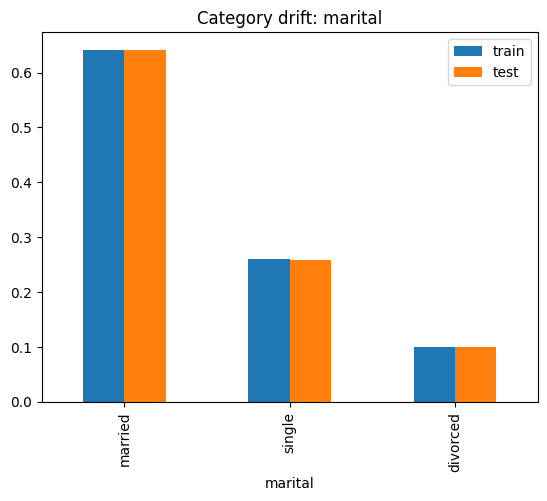

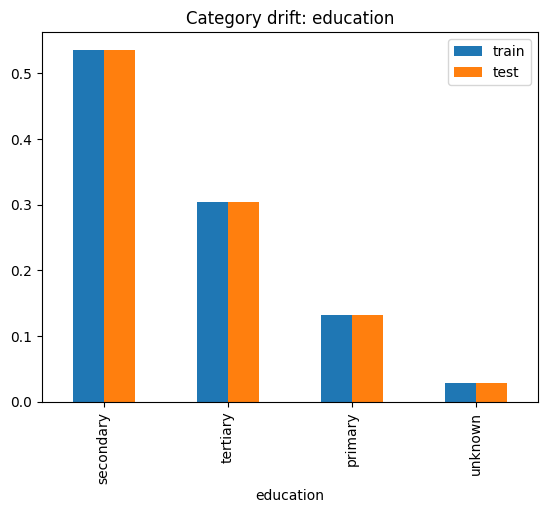

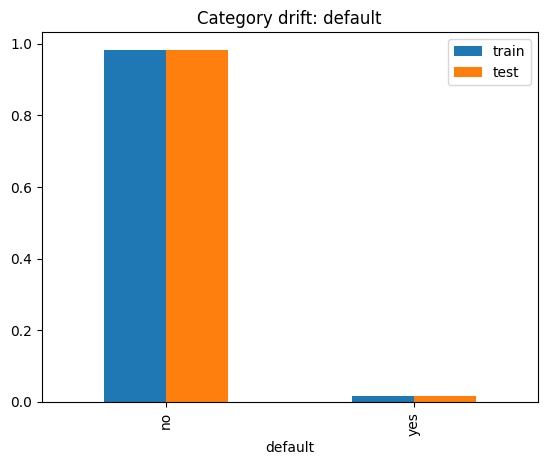

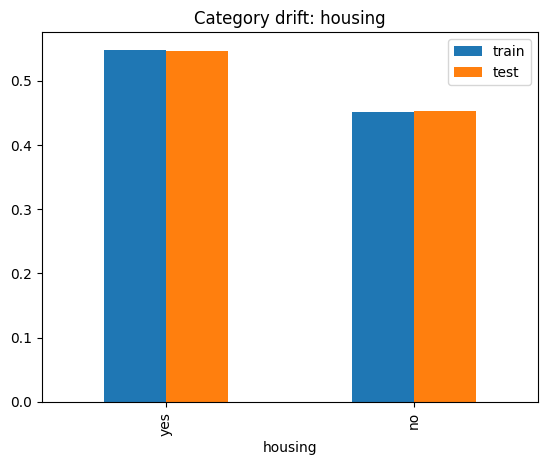

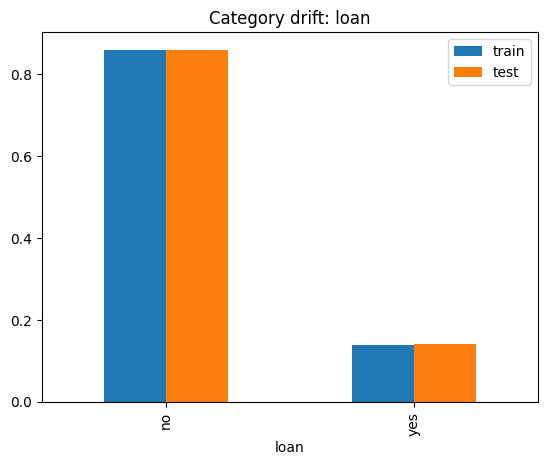

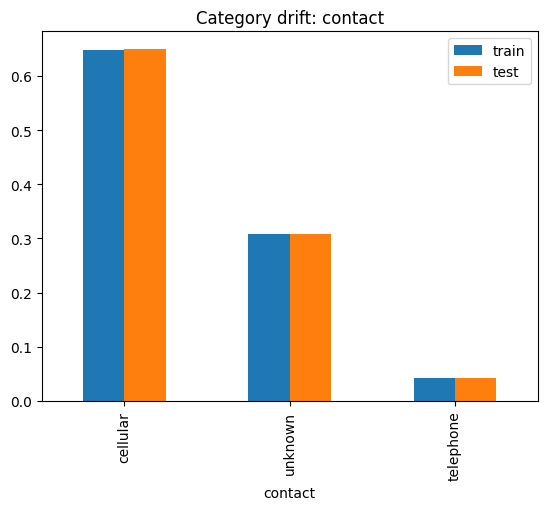

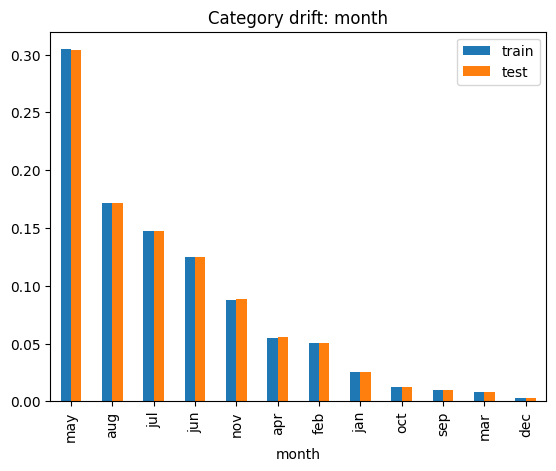

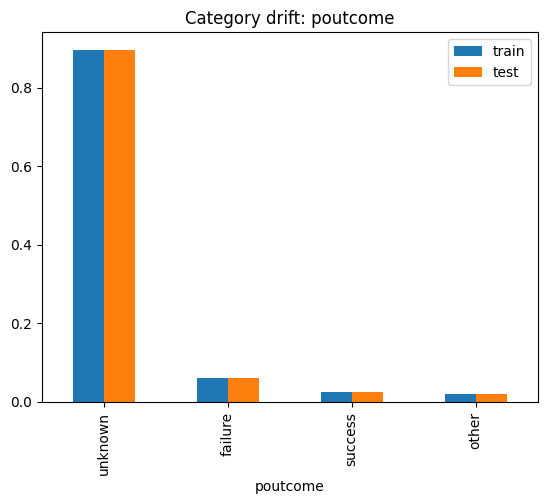

In [14]:
def plot_category_drift(feature):
    pd.concat([
        train_df[feature].value_counts(normalize=True).rename("train"),
        test_df[feature].value_counts(normalize=True).rename("test")
    ], axis=1).plot(kind="bar", title=f"Category drift: {feature}")

columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome'  ]

for col in columns:
    plot_category_drift(col)

### Key Observations:
- no clear drift between train and test data

## 4. Correlation check for train and test data

 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object

<Axes: >

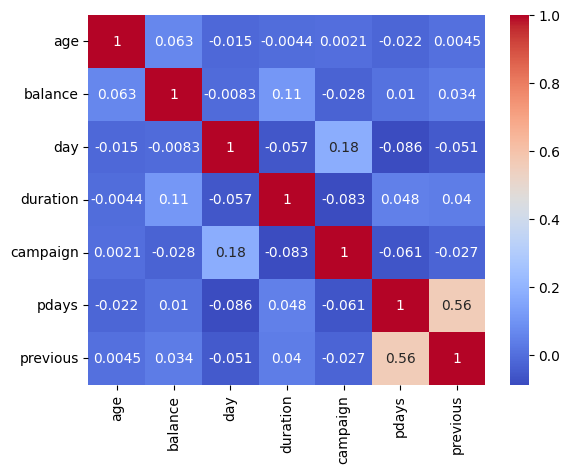

In [15]:
sns.heatmap(train_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous']].corr(),
            annot = True, cmap='coolwarm')

<Axes: >

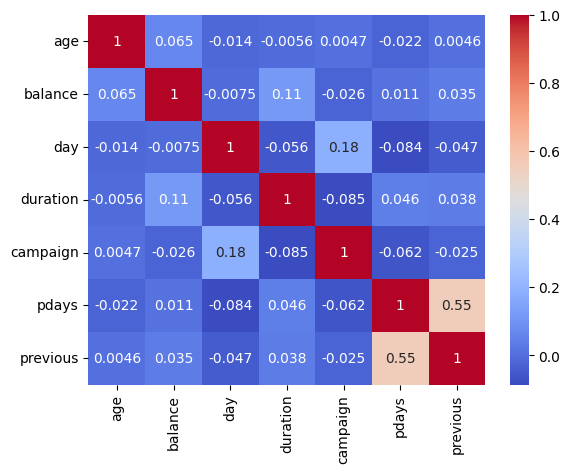

In [16]:
sns.heatmap(test_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous']].corr(), 
            annot = True, cmap='coolwarm')

### Key Observations:
- The Time_spend_alone column has a negative correlation with all the other columns
- The remaining columns have also quite strong correlation with each other
- The correlations for training and test data look very similar

## 5. Check of 'y' in each column for train data

y
0    87.93
1    12.07
Name: proportion, dtype: float64

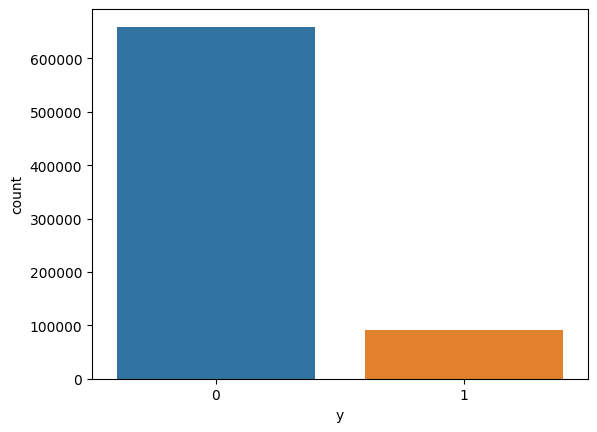

In [17]:
sns.countplot(data=train_df, x='y')
round(train_df['y'].value_counts(normalize=True)*100,2)

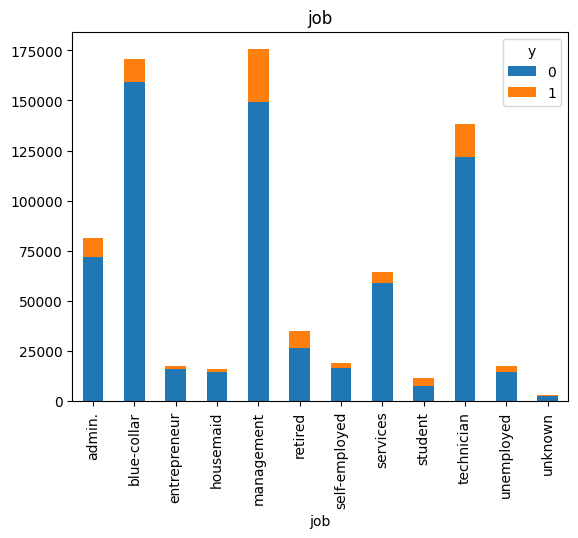

y,0,1
job,,
admin.,88.4,11.6
blue-collar,93.3,6.7
entrepreneur,91.9,8.1
housemaid,91.5,8.5
management,85.0,15.0
retired,75.4,24.6
self-employed,87.1,12.9
services,91.7,8.3
student,65.9,34.1


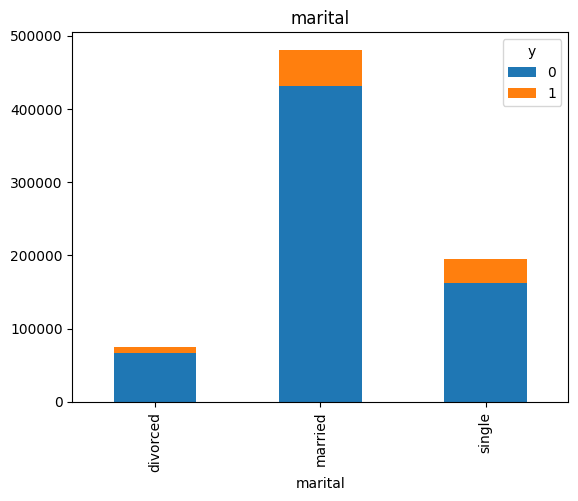

y,0,1
marital,,
divorced,88.8,11.2
married,89.8,10.2
single,83.0,17.0


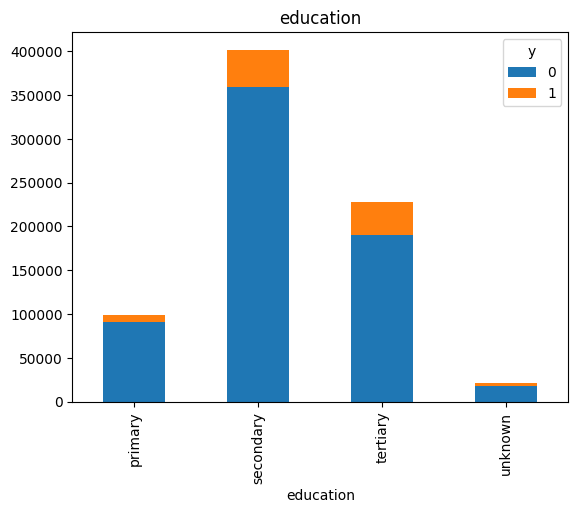

y,0,1
education,,
primary,91.7,8.3
secondary,89.5,10.5
tertiary,83.7,16.3
unknown,86.7,13.3


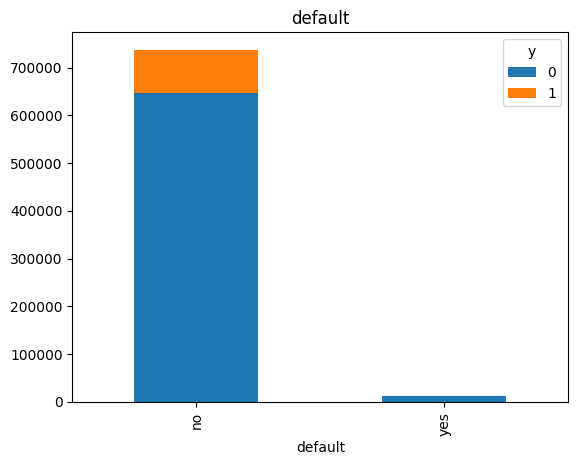

y,0,1
default,,
no,87.8,12.2
yes,95.4,4.6


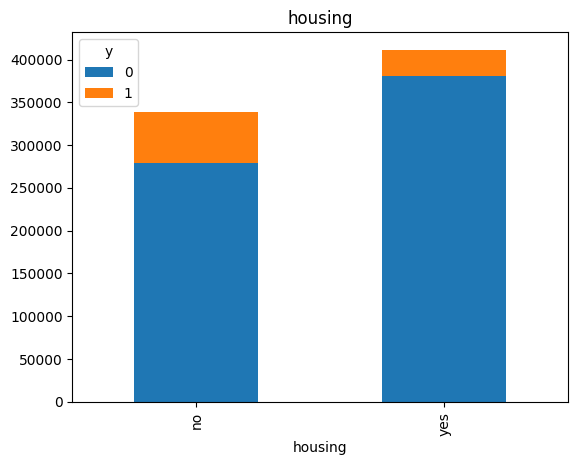

y,0,1
housing,,
no,82.4,17.6
yes,92.5,7.5


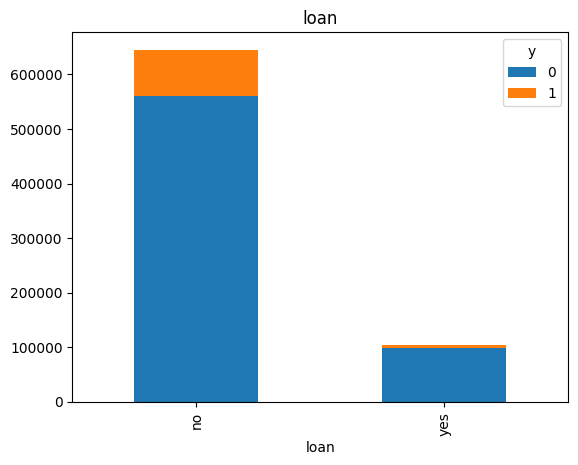

y,0,1
loan,,
no,86.9,13.1
yes,94.5,5.5


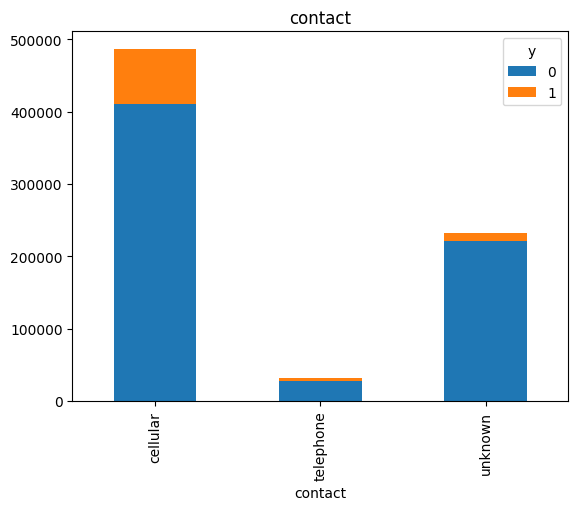

y,0,1
contact,,
cellular,84.3,15.7
telephone,86.3,13.7
unknown,95.7,4.3


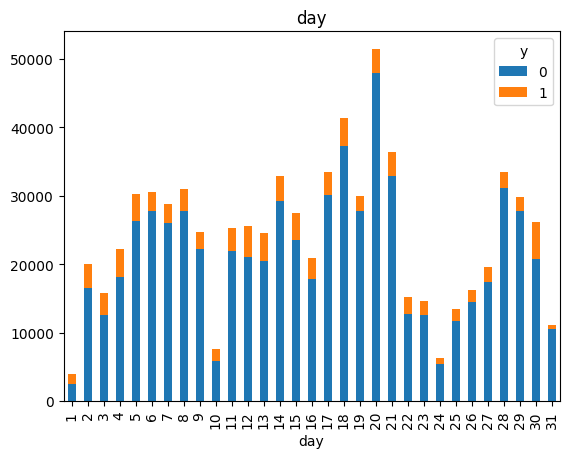

y,0,1
day,,
1,64.2,35.8
2,82.5,17.5
3,79.6,20.4
4,81.4,18.6
5,86.7,13.3
6,90.7,9.3
7,90.2,9.8
8,89.4,10.6
9,89.6,10.4


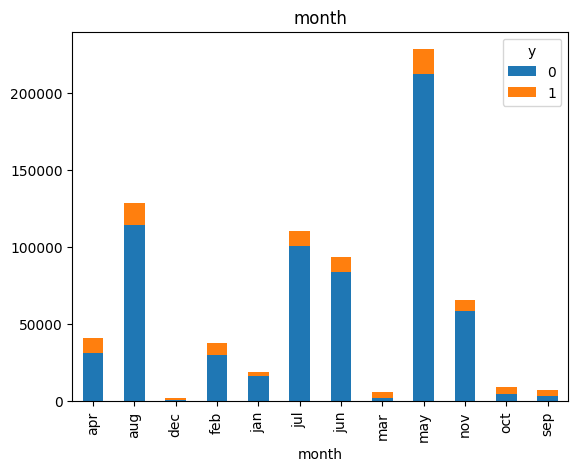

y,0,1
month,,
apr,76.4,23.6
aug,88.8,11.2
dec,48.7,51.3
feb,79.3,20.7
jan,87.6,12.4
jul,90.9,9.1
jun,89.6,10.4
mar,42.9,57.1
may,92.9,7.1


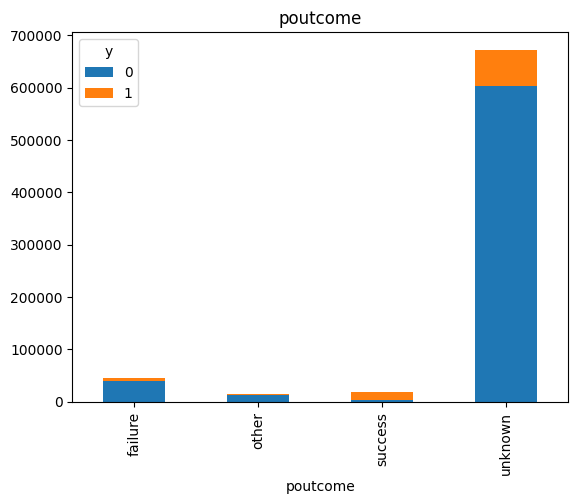

y,0,1
poutcome,,
failure,86.7,13.3
other,83.3,16.7
success,23.6,76.4
unknown,89.8,10.2


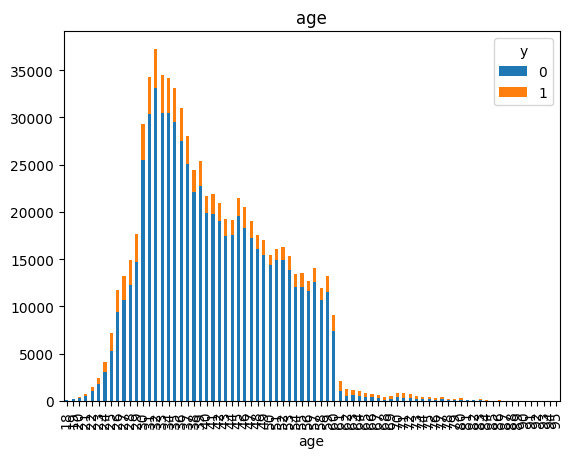

y,0,1
age,,
18,63.7,36.2
19,69.4,30.6
20,71.4,28.6
21,72.0,28.0
22,68.5,31.5
...,...,...
91,0.0,100.0
92,60.0,40.0
93,0.0,100.0


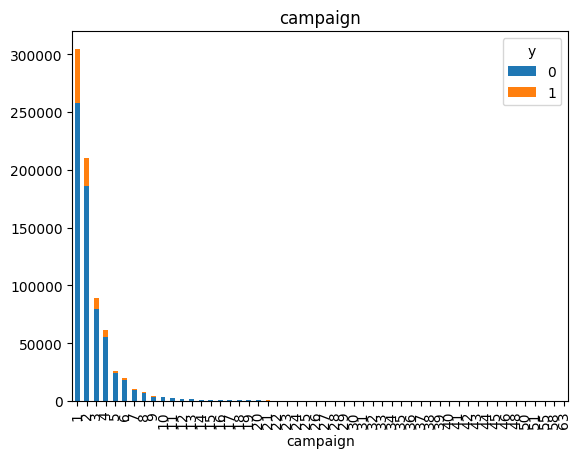

y,0,1
campaign,,
1,84.7,15.3
2,88.6,11.4
3,89.4,10.6
4,91.3,8.7
5,93.0,7.0
6,93.1,6.9
7,93.5,6.5
8,93.9,6.1
9,92.5,7.5


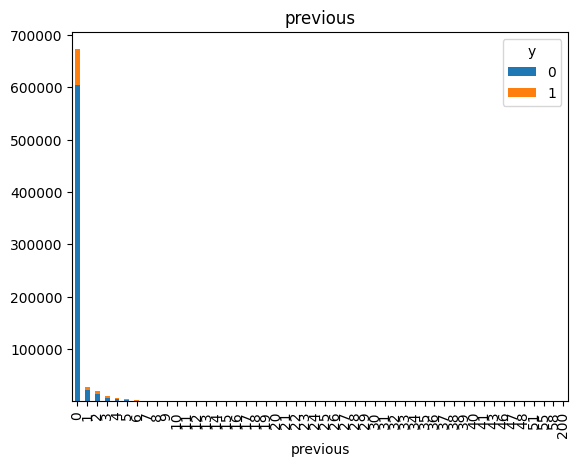

y,0,1
previous,,
0,89.8,10.2
1,74.3,25.7
2,73.8,26.2
3,66.8,33.2
4,69.6,30.4
5,67.5,32.5
6,61.7,38.3
7,66.9,33.1
8,62.9,37.1


In [18]:
columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month' , 'poutcome', 'age', 'campaign', 'previous']
for col in columns:
    train_df.groupby([col,'y']).size().unstack().plot(kind='bar', stacked=True, title=col)
    plt.show()
    display((pd.crosstab(train_df[col], train_df["y"], normalize='index') * 100).round(1))

In [24]:
test_df['month'].value_counts(normalize=True)*100

month
may    30.4036
aug    17.1496
jul    14.7312
jun    12.4780
nov     8.8148
apr     5.5512
feb     5.0064
jan     2.5764
oct     1.2616
sep     0.9716
mar     0.7776
dec     0.2780
Name: proportion, dtype: float64

In [33]:
train_df['month'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

<Axes: title={'center': 'col'}, xlabel='month'>

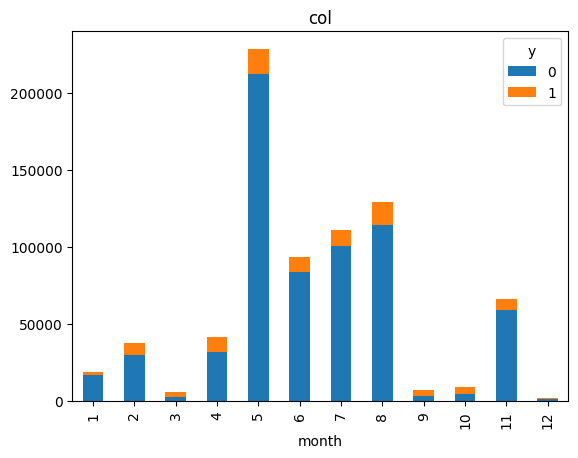

In [34]:
train_df.groupby(['month','y']).size().unstack().plot(kind='bar', stacked=True, title='col')

## Element	Ocena
## Czy dane są cykliczne?	❌ Raczej nie
## Czy traktować miesiąc jako liczbową cechę?	❌ Nie
## Czy użyć kodowania sin/cos?	❌ Niepotrzebne
## Najlepsze kodowanie do XGBoost	✅ One-Hot Encoding lub Target Encoding (z ostrożnością)


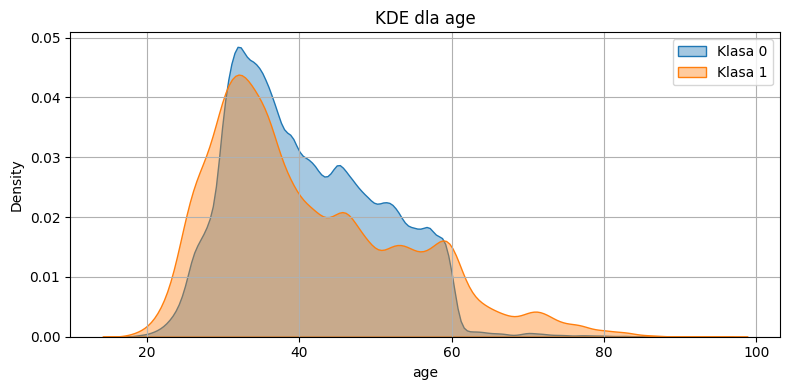

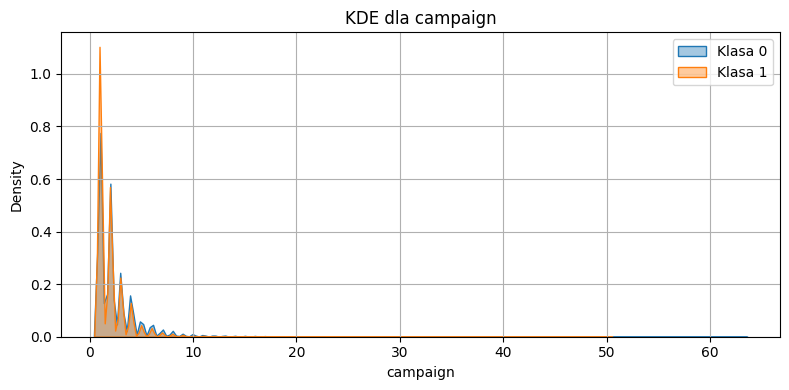

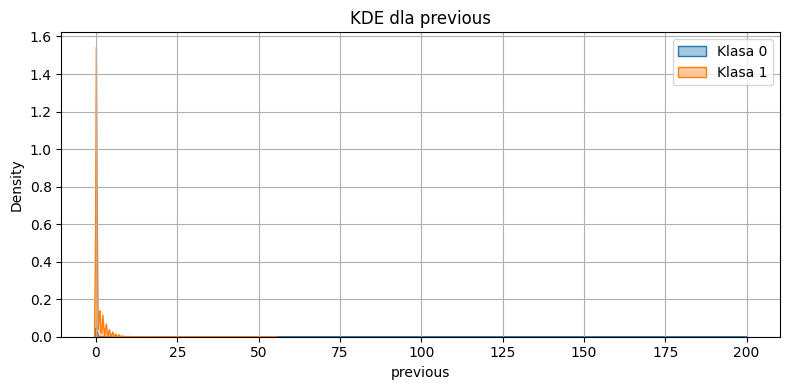

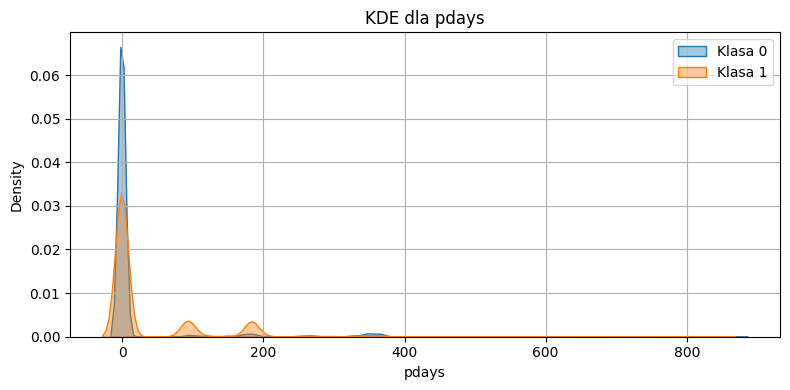

In [19]:
columns = [ 'age', 'campaign', 'previous', 'pdays']

for feature in columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, label='Klasa 0', fill=True, alpha=0.4)
    sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, label='Klasa 1', fill=True, alpha=0.4)
    plt.title(f'KDE dla {feature}')
    #plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

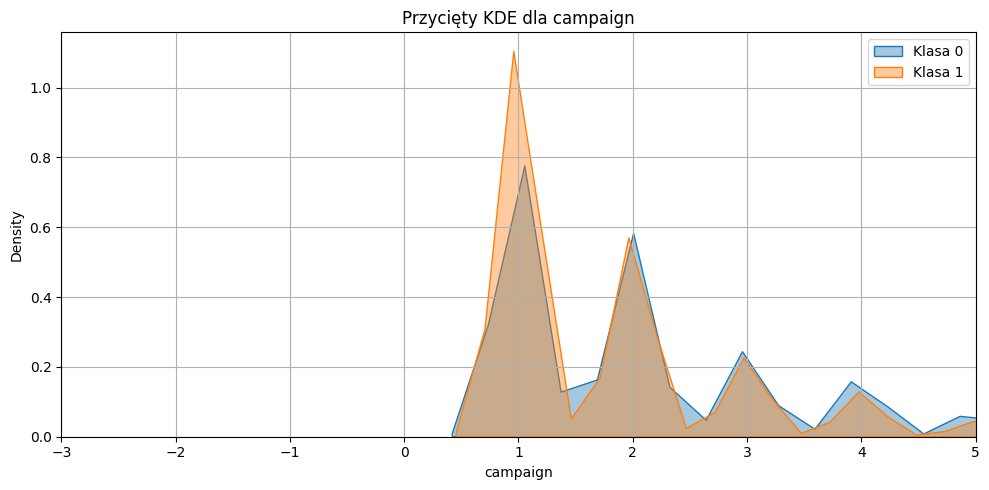

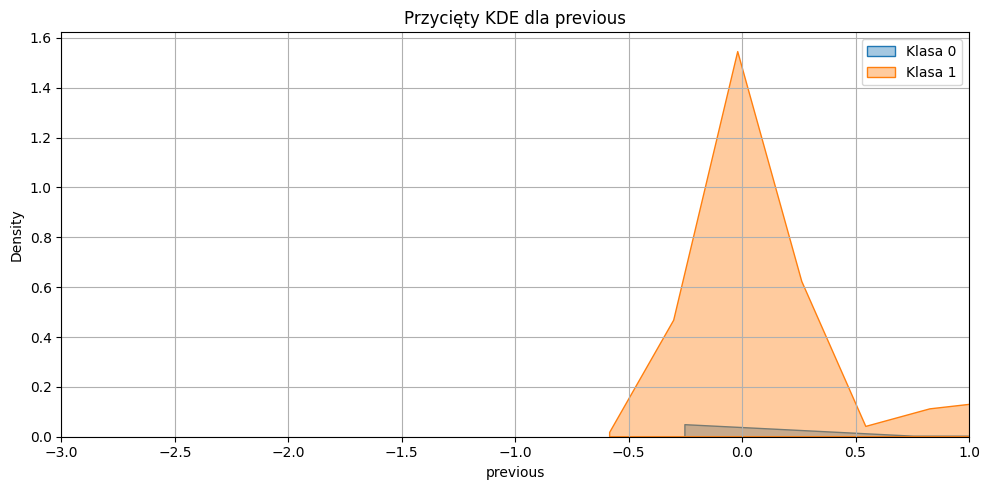

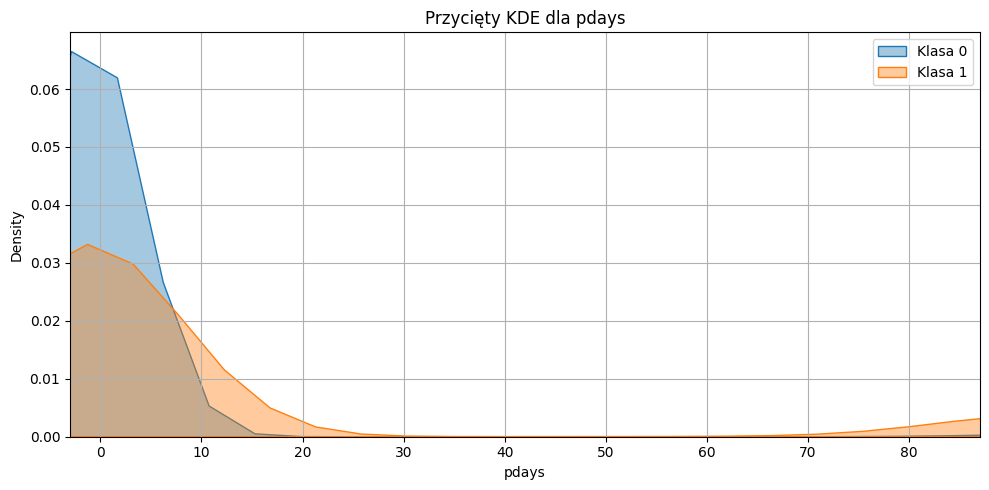

In [20]:
columns = [ 'campaign', 'previous', 'pdays']

for feature in columns:

    upper_limit = train_df[feature].quantile(0.9)  # lub np. 50, jeśli chcesz ręcznie
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, label='Klasa 0', fill=True, alpha=0.4)
    sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, label='Klasa 1', fill=True, alpha=0.4)
    plt.xlim(-3, upper_limit)
    plt.title(f'Przycięty KDE dla {feature}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

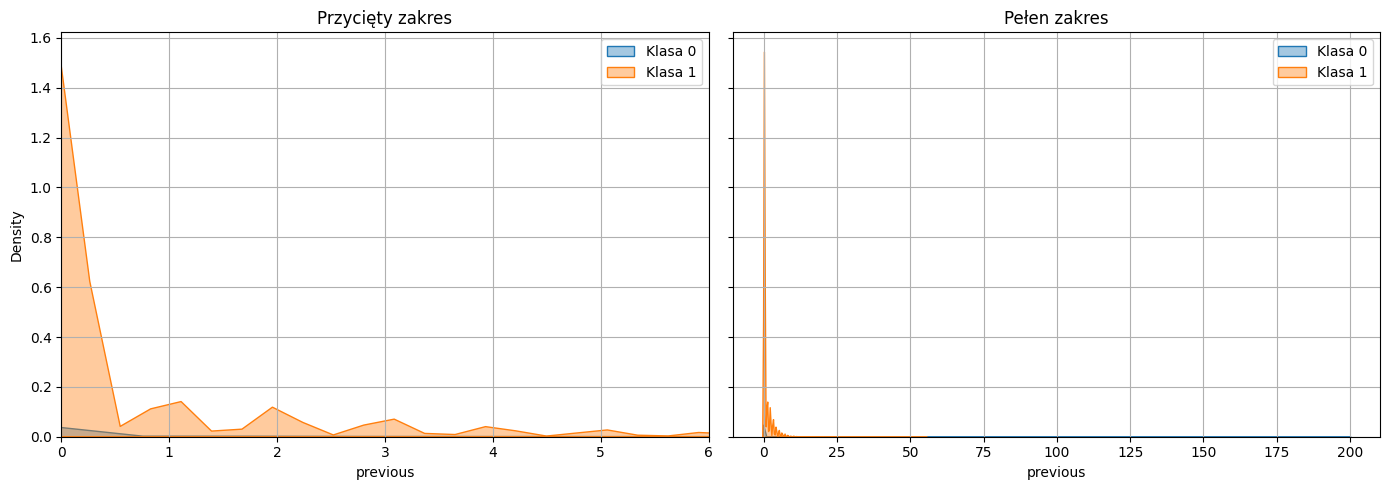

In [21]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Przycięty
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='Klasa 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='Klasa 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title('Przycięty zakres')

# Pełen
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='Klasa 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='Klasa 1', fill=True, alpha=0.4)
axes[1].set_title('Pełen zakres')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

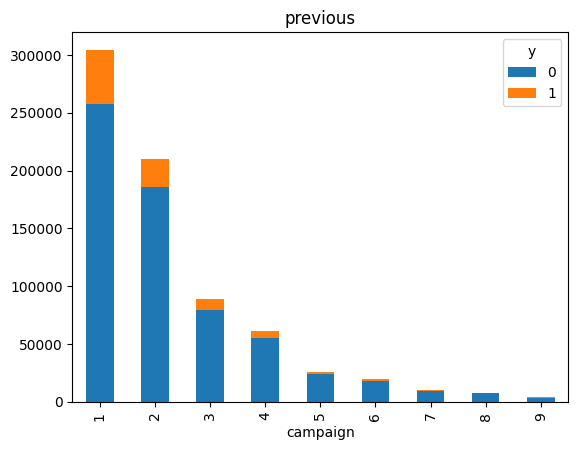

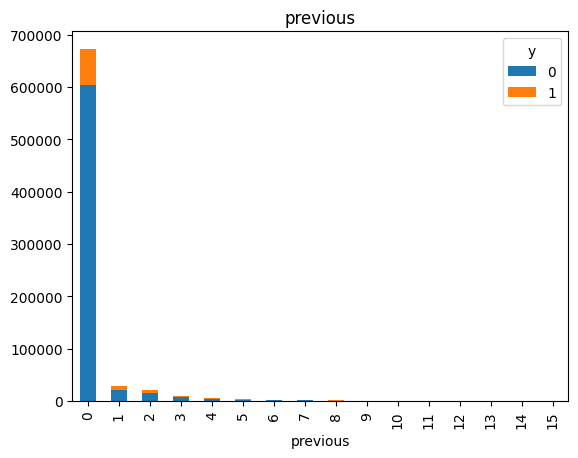

In [22]:
columns = ['campaign', 'previous']

train_df[train_df['campaign']<10].groupby(['campaign','y']).size().unstack().plot(kind='bar', stacked=True, title=col)
plt.show()

train_df[train_df['previous']<16].groupby(['previous','y']).size().unstack().plot(kind='bar', stacked=True, title=col)
plt.show()

    #display((pd.crosstab(train_df[col], train_df["y"], normalize='index') * 100).round(1))

### Key Observations:
- We have 2 gropus in label column with split 74% 26% - classes are not balanced
- Data in numeric column are integer
- Each column show integer values dominated by one group, transition integer values and values dominated by other group
- Stage_fear and Drained_after_socializing columns show strong polarisation of data and similar character
- There is no clear integer values column that is only introvert or extrovert

1. Czasowe i kampanijne zależności
⏱️ „Długość kontaktu” / „liczba kontaktów”
kontakt_avg_time = duration / campaign – średni czas kontaktu na jeden kontakt

📉 Trend kontaktów
delta_contact = previous - campaign – czy liczba kontaktów wzrosła czy spadła

has_previous_contact = (pdays != 999).astype(int) – flaga, czy kontakt był wcześniej

📅 Sezonowość
Zmienna month – zakoduj ją jako int (np. Jan = 1) i dodaj zmienną:

is_q4_campaign = month.isin(['oct', 'nov', 'dec']) – może zimą skuteczność spada?

🧑‍💼 2. Zachowanie klienta i profil demograficzny
💳 Zobowiązania finansowe
loan_sum = (housing == 'yes') + (loan == 'yes') – liczba aktywnych pożyczek

is_deep_debt = (balance < 0) & (loan_sum > 1) – mocno zadłużony

🧠 Poziom edukacji + zawód
edu_job = education + "_" + job – np. "tertiary_admin"

Można zakodować i użyć jako cechy (one-hot lub target encoding)

👫 Małżeństwo vs. wiek
is_young_single = (age < 30) & (marital == 'single')

is_old_married = (age > 60) & (marital == 'married')

📞 3. Komunikacja i kanał kontaktu
🔔 Efektywność kanału kontaktu
contact_success_rate = campaign / (duration + 1) – ile kontaktów na minutę

🛠️ Rodzaj komunikacji + sukces poprzedni
channel_prev_success = contact + "_" + poutcome



🧪 Narzędzia do wykrywania nieliniowych zależności:
pd.plotting.scatter_matrix() – szybki rzut oka

sns.pairplot() – dla małej liczby kolumn

sklearn.feature_selection.mutual_info_classif(X, y) – mierzy nieliniową zależność

1. Numeryczne ↔ Numeryczne
Pairplot (sns.pairplot)
Kilka zmiennych naraz – przegląd zależności i gęstości
sns.pairplot(df, hue='label')  # opcjonalnie hue dla klasy binarnej

Scatterplot z hue / style / size
Super do odkrywania nieliniowych relacji
sns.scatterplot(data=df, x='age', y='balance', hue='loan', style='marital')

Heatmap korelacji (sns.heatmap)
Pokazuje mocne lub słabe powiązania liniowe
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

2. Kategoryczne ↔ Numeryczne
Boxplot (sns.boxplot)
Widać mediany, rozrzut i outliery
sns.boxplot(data=df, x='education', y='balance')

Violinplot (sns.violinplot)
To samo co boxplot, ale z KDE – pokazuje lepiej gęstości
sns.violinplot(data=df, x='job', y='age', hue='y', split=True)

Swarmplot (sns.swarmplot)
Każdy punkt osobno – dobry na małych zbiorach
sns.swarmplot(data=df, x='marital', y='balance')

Barplot (sns.barplot)
Średnia wartość cechy numerycznej dla kategorii (np. średni balance dla job)
sns.barplot(data=df, x='job', y='balance')

 3. Kategoryczne ↔ Kategoryczne
Heatmap cross-tab (pd.crosstab + sns.heatmap)
Ile wystąpień danego połączenia
ct = pd.crosstab(df['job'], df['marital'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')

Countplot (sns.countplot)
Liczba obserwacji w każdej kategorii + hue np. y
sns.countplot(data=df, x='education', hue='y')

4. Numeryczne ↔ Target binarny
KDE Plot (sns.kdeplot)
Rozkład cechy w dwóch klasach
sns.kdeplot(data=df[df['y'] == 0], x='age', label='No Loan')
sns.kdeplot(data=df[df['y'] == 1], x='age', label='Loan Taken')

Histogram + hue
sns.histplot(data=df, x='balance', hue='y', bins=30, kde=True, stat='density')
🔹 5. Dodatkowe / Interaktywne
✅ FacetGrid
Podzielone wykresy np. według marital i education
g = sns.FacetGrid(df, col="marital", row="education", hue="y")
g.map(sns.kdeplot, "age", fill=True)

jointplot (sns.jointplot)
Scatter + marginesowe rozkłady
sns.jointplot(data=df, x='balance', y='duration', hue='y', kind='kde')



## 6. Detailed check of categorical columns properties

In [23]:
sns.catplot(
    data=train_df[train_df['Personality'].isin(['Introvert', 'Extrovert'])],  
    x="Stage_fear",
    hue="Personality",
    col="Drained_after_socializing",
    kind="count",
    height=4,
    aspect=1
)
plt.suptitle("Rozkład StageFear wg osobowości", y=1.05)
plt.show()

KeyError: 'Personality'

In [ ]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

### Key Observations:
- Stage_fear and Drained_after_socializing columns seems to be strong indicator of classification
- In each column there is small representation of opposite group prefference (Extrovert preffers No & No, but there is small group of introverts with same prefferences)
- It is very rare situation to have Yes - No and No - Yes answers. It is very specific minor group
- It may be resonable to impute data Yes when other column is Yes and oposite for No, for such rare cases


####  Below we check what would be result of imputation Yes to Yes and No to No for both ways

In [ ]:
cat_cols1 = ['Stage_fear','Drained_after_socializing']
all_train_df=train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
all_train_df[cat_cols1]=all_train_df[cat_cols1].fillna('Missing').astype(str)
display(pd.crosstab([all_train_df['Personality'],all_train_df["Stage_fear"]],all_train_df["Drained_after_socializing"]  ))


help_train_df = train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
help_train_df['Stage_fear'] = help_train_df['Stage_fear'].mask(help_train_df['Stage_fear'].isna() & help_train_df['Drained_after_socializing']
                                            .notna(), help_train_df['Drained_after_socializing'])
help_train_df['Drained_after_socializing'] = help_train_df['Drained_after_socializing'].mask(help_train_df['Drained_after_socializing']
                                            .isna() & help_train_df['Stage_fear'].notna(), help_train_df['Stage_fear'])
help_train_df[cat_cols1]=help_train_df[cat_cols1].fillna('Missing').astype(str)

display(pd.crosstab(help_train_df['Stage_fear'],help_train_df['Personality']))

### Key Observations:
- There is only 39 missing values for both categorical columns and for total 18524 rows it seems to be a good imputation stratego - to be tested

## 7. Detailed check of No-No / Yes-Yes data regarding Introverts & Extroverts groups

In [ ]:
train_introvert_df = train_df[train_df['Personality']=='Introvert']
train_extrovert_df = train_df[train_df['Personality']=='Extrovert']

In [ ]:
introvert_no_no_df = train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Introvert')]
extrovert_yes_yes_df = train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Extrovert')]

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

In [ ]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        plt.legend()
        plt.show()

### Key Observations:
- It seems like main problem of this classification. No-No answer is typical for Extroverts but some Introverts have same prefferences like No-No and has similar values for other colums (Post_frequency, Going_outsice...) like Extroverts
- It will be extremly hard for classifiers to deal with such situation. There is some space in overlaping area between yes-yes and no-no groups and it can be marked with 0 and 1 giving clear information to model that is border condition. - Can be tested 

In [ ]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)

        plt.legend()
        plt.show()

### Markers to be tested:
- 'Time_spent_Alone' == 4
- 'Social_event_attendance' == 3
- 'Going_outside' ==3
- 'Friends_circle_size' == 5
- 'Post_frequency' == 3

## 8. Missing values - looking for signals

In [ ]:
excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

In [ ]:
columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)
    result = pd.crosstab(train_df[col],train_df['Personality'], normalize='index')*100
    chi2, p, _, _ = chi2_contingency(result)
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f} Column: {col} ")

### Key Observations:
- Columns Stage_fear_MISS and Drained_after_socializing_MISS have p-value lower then 0.05 so they can be considered as potential signal for different distribution of Introverts/Extroverts

## 9. Missing values - total number of non-missing data

In [ ]:
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)
train_df.groupby(['not_MISS_total','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Data without NaN values')
pd.crosstab(train_df['not_MISS_total'],train_df['Personality'], normalize='index')*100

### Key Observations:
- When number of missing values for one person increase it is observed that percentage of introverts in such grup increases too. 

## 10. Advanced Data Imputation 

In [ ]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']    
cat_cols = ['Stage_fear', 'Drained_after_socializing']     

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])

columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)


## 11. Realations check between columns

### Time_spent_Alone / Going_outside

In [ ]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Time_Alone_dev_Outside"],train_df['Personality'],normalize='index')*100 

### Key Observations:
- If columns Time_spent_Alone / Going_outside are devided we can observed quite good separation of data
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Social_event_attendance / Post_frequency

In [ ]:
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
## Alternatywne grupowanie
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)

def Social_dev_Post (x):
    try:
        x=float(x)
        if x == 0:
            return 0
        elif x > 0 and x < 0.33:
            return 1
        elif x == 0.33:
            return 2
        elif x > 0.33 and x < 0.5:
            return 1
        elif x == 0.5:
            return 4
        elif x > 0.5 and x < 0.67:
            return 1
        elif x == 0.67:
            return 4
        elif x > 0.67 and x < 1:
            return 1
        elif x == 1:
            return 4
        elif x > 1 and x < 1.5:
            return 1
        elif x == 1.5:
            return 4
        elif x > 1.5 and x < 2:
            return 1
        elif x == 2:
            return 4
        elif x > 2 and x < 3:
            return 1
        elif x == 3:
            return 2
        elif x > 3 and x < 100:
            return 1
        else:
            return 0
    except ValueError:
        return 0

train_df['Social_dev_Post']=train_df['Social_dev_Post'].apply(Social_dev_Post).astype('Int64')
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Social_dev_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Social_event_attendance / Post_frequency are devided we can observed quite good separation of data in fixed points
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside * Friends_circle_size

In [ ]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Outside_mult_Friends"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside * Friends_circle_size are multiplied we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside - Post_frequency

In [ ]:
train_df['Going_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= -6:
            return 0
        elif x == -5 or x== -4 or x==4:
            return 1
        elif x == -3 or x== 3:
            return 2
        elif x == -2 or x== 2:
            return 3
        elif x == -1 or x== 0 or x==1:
            return 4
        elif x >= 5:
            return 5
        else:
            return 6
    except ValueError:
        return 6

train_df['Going_sub_Post']=train_df['Going_sub_Post'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Going_sub_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside - Post_frequency are subtracted from each other we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups
- group 0 is still not pure group

## 12. Realations check between columns - Other 

## Columns subtraction

In [ ]:
train_df['subtraction']=train_df['Friends_circle_size'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Column summing

In [ ]:
train_df['Summary']=train_df['Friends_circle_size'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Going_outside'] + train_df['Friends_circle_size']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Going_outside'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [ ]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Going_outside']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Other column multiplications and divisions

In [ ]:
train_df['Time_alona_outside'] = train_df['Going_outside'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Social_event_attendance']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alone_friends_circle'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alone_friends_circle','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Social_event_attendance']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Friends_circle_size'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


### Key Observations:
- For checked interactions there is no pure separation between Extroverts and Introverts
- Some additional features can be created to be tested, if there is improvement in classification
